# Project 1: Sex Differences in brain organization

### Main Script: Sex classification

## Load packages

In [1]:
# General
import os
import sys
import numpy as np
import pandas as pd
import csv
import math
from math import isnan
import statistics
#import pingouin as pg
import pickle

# Computing
import scipy.io  # loadmat
from scipy import stats
import sklearn 
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM

# Visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
import vtk
from IPython.display import display
import matplotlib.collections as clt
#import ptitprince as pt

# Neuroimaging
import nibabel
import nilearn
from brainstat.datasets import fetch_parcellation
#from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Gradients
import brainspace
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

# ML using scikit learn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

from sklearn.feature_selection import SequentialFeatureSelector as SFS

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'

resdir_gsp = '/data/p_02667/sex_diff_gradients/results/GSP/'
resdir_hcp = '/data/p_02667/sex_diff_gradients/results/HCP/'

## Define functions

#### Confound removal
https://academic.oup.com/gigascience/article/doi/10.1093/gigascience/giac014/6547681#339860007
https://github.com/darya-chyzhyk/confound_prediction

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConfoundRegressor(BaseEstimator, TransformerMixin):
    """ Fits a confound onto each feature in X and returns their residuals."""

    def __init__(self, confound, X, cross_validate=True, precise=False,
                 stack_intercept=True):
        """ Regresses out a variable (confound) from each feature in X.

        Parameters
        ----------
        confound : numpy array
            Array of length (n_samples, n_confounds) to regress out of each
            feature; May have multiple columns for multiple confounds.
        X : numpy array
            Array of length (n_samples, n_features), from which the confound
            will be regressed. This is used to determine how the
            confound-models should be cross-validated (which is necessary
            to use in in scikit-learn Pipelines).
        cross_validate : bool
            Whether to cross-validate the confound-parameters (y~confound)
            estimated from the train-set to the test set (cross_validate=True)
            or whether to fit the confound regressor separately on the test-set
            (cross_validate=False). Setting this parameter to True is equivalent
            to "foldwise confound regression" (FwCR) as described in our paper
            (https://www.biorxiv.org/content/early/2018/03/28/290684). Setting
            this parameter to False, however, is NOT equivalent to "whole
            dataset confound regression" (WDCR) as it does not apply confound
            regression to the *full* dataset, but simply refits the confound
            model on the test-set. We recommend setting this parameter to True.
        precise: bool
            Transformer-objects in scikit-learn only allow to pass the data
            (X) and optionally the target (y) to the fit and transform methods.
            However, we need to index the confound accordingly as well. To do so,
            we compare the X during initialization (self.X) with the X passed to
            fit/transform. As such, we can infer which samples are passed to the
            methods and index the confound accordingly. When setting precise to
            True, the arrays are compared feature-wise, which is accurate, but
            relatively slow. When setting precise to False, it will infer the index
            by looking at the sum of all the features, which is less accurate, but much
            faster. For dense data, this should work just fine. Also, to aid the
            accuracy, we remove the features which are constant (0) across samples.
        stack_intercept : bool
            Whether to stack an intercept to the confound (default is True)

        Attributes
        ----------
        weights_ : numpy array
            Array with weights for the confound(s).
        """

        self.confound = confound
        self.cross_validate = cross_validate
        self.X = X
        self.precise = precise
        self.stack_intercept = stack_intercept
        self.weights_ = None
        self.nonzero_X_ = None


    def fit(self, X, y=None):
        """ Fits the confound-regressor to X.

        Parameters
        ----------
        X : numpy array
            An array of shape (n_samples, n_features), which should correspond
            to your train-set only!
        y : None
            Included for compatibility; does nothing.
        """

        if self.stack_intercept:
            icept = np.ones(self.confound.shape[0])
            self.confound = np.c_[icept, self.confound]

        # Find nonzero voxels (i.e., voxels which have not all zero
        # values across samples)
        if self.nonzero_X_ is None:
            self.nonzero_X_ = np.sum(self.X, axis=0) != 0
            self.X = self.X[:, self.nonzero_X_]

        X_nz = X[:, self.nonzero_X_]
        confound = self.confound

        if self.precise:
            tmp = np.in1d(self.X, X_nz).reshape(self.X.shape)
            fit_idx = tmp.sum(axis=1) == self.X.shape[1]
        else:
            fit_idx = np.in1d(self.X.sum(axis=1), X_nz.sum(axis=1))

        confound_fit = confound[fit_idx, :]

        # Vectorized implementation estimating weights for all features
        self.weights_ = np.linalg.lstsq(confound_fit, X_nz, rcond=None)[0]
        return self


    def transform(self, X):
        """ Regresses out confound from X.

        Parameters
        ----------
        X : numpy array
            An array of shape (n_samples, n_features), which should correspond
            to your train-set only!

        Returns
        -------
        X_new : ndarray
            ndarray with confound-regressed features
        """

        if not self.cross_validate:
            self.fit(X)

        X_nz = X[:, self.nonzero_X_]

        if self.precise:
            tmp = np.in1d(self.X, X_nz).reshape(self.X.shape)
            transform_idx = tmp.sum(axis=1) == self.X.shape[1]
        else:
            transform_idx = np.in1d(self.X.sum(axis=1), X_nz.sum(axis=1))

        confound_transform = self.confound[transform_idx]
        X_new = X - confound_transform.dot(self.weights_)
        X_corr = np.zeros_like(X)
        X_corr[:, self.nonzero_X_] = X_new
        return X_corr

## Import data

In [4]:
# demographics data
GSP_demographics_cleaned = pd.read_csv(resdir_gsp+'demographics_cleaned.csv')
HCP_demographics_cleaned = pd.read_csv(resdir_hcp+'demographics_cleaned.csv')

# CT data
GSP_ct_schaefer400 = pd.read_csv(resdir_gsp+'ct_schaefer400.csv')
HCP_ct_schaefer400 = pd.read_csv(resdir_hcp+'ct_schaefer400.csv')

# functional gradient (visual-heteromodal) data
GSP_fc_grad = pd.read_csv(resdir_gsp+'array_aligned_fc_G2.csv')  # G2
HCP_fc_grad = pd.read_csv(resdir_hcp+'array_aligned_fc_G1.csv')  # G1

In [5]:
# rename some data columns to make them same across samples
GSP_demographics_cleaned = GSP_demographics_cleaned.rename(columns={'Sex': 'sex', 'Age_Bin': 'age', 'ICV': 'icv'})
HCP_demographics_cleaned = HCP_demographics_cleaned.rename(columns={'Gender': 'sex', 'Age_in_Yrs': 'age', 'FS_IntraCranial_Vol': 'icv'})

## Classification with cross validation (within GSP sample)

### local structure

In [11]:
##### define predictor and target variables

### target: sex
y_GSP = GSP_demographics_cleaned['sex']


### predictor: brain data (400 parcels)

x_GSP = GSP_ct_schaefer400

## confound removal

# make a preprocessor confound regressor
confound_regressor = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'global_ct']]), X = np.array(x_GSP))

# fit it to the predictor data
_ = confound_regressor.fit(X = np.array(x_GSP))

# transform the predictor data with confound variables regressed out
x_GSP_unconf = confound_regressor.transform(X = np.array(x_GSP))



##### create model via pipeline

# Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))



##### within sample cross valiation using stratifued and shuffled k-fold

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#skf.split(x_GSP_unconf, y_GSP)
scores = cross_val_score(model, x_GSP_unconf, y_GSP, cv=skf)


print(f"the mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

the mean cross-validation accuracy is: 0.837 +/- 0.021


### functional gradient


if I need to be able to distinguish the func/struct data (parcels): df = df.add_suffix('_some_suffix')

In [12]:
##### define predictor and target variables

### target: sex
y_GSP = GSP_demographics_cleaned['sex']


### predictor: brain data (400 parcels)

x_GSP = GSP_fc_grad

## confound removal

# make a preprocessor confound regressor
confound_regressor = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'icv']]), X = np.array(x_GSP))

# fit it to the predictor data
_ = confound_regressor.fit(X = np.array(x_GSP))

# transform the predictor data with confound variables regressed out
x_GSP_unconf = confound_regressor.transform(X = np.array(x_GSP))



##### create model via pipeline

# Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))



##### within sample cross valiation using stratifued and shuffled k-fold

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#skf.split(x_GSP_unconf, y_GSP)
scores = cross_val_score(model, x_GSP_unconf, y_GSP, cv=skf)


print(f"the mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

the mean cross-validation accuracy is: 0.599 +/- 0.028


### local structure and functional gradient

In [14]:
##### define predictor and target variables

### target: sex
y_GSP = GSP_demographics_cleaned['sex']


### predictor: brain data (400 parcels)

x_GSP_struct = GSP_ct_schaefer400
x_GSP_func = GSP_fc_grad


## confound removal (removing structural and functional data's confounding variables respectively)

# make a preprocessor confound regressor
confound_regressor_struct = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'global_ct']]), X = np.array(x_GSP_struct))
confound_regressor_func = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'icv']]), X = np.array(x_GSP_func))

# fit it to the predictor data
_ = confound_regressor_struct.fit(X = np.array(x_GSP_struct))
_ = confound_regressor_func.fit(X = np.array(x_GSP_func))

# transform the predictor data with confound variables regressed out
x_GSP_struct_unconf = confound_regressor_struct.transform(X = np.array(x_GSP_struct))
x_GSP_func_unconf = confound_regressor_func.transform(X = np.array(x_GSP_func))

# concatenate the two arrays stored in one predictor variable (800 parcels (400 structural, 400 functional)
x_GSP_unconf = np.concatenate((x_GSP_struct_unconf, x_GSP_func_unconf), axis = 1)



##### create model via pipeline

# Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))



##### within sample cross valiation using stratifued and shuffled k-fold

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#skf.split(x_GSP_unconf, y_GSP)
scores = cross_val_score(model, x_GSP_unconf, y_GSP, cv=skf)


print(f"the mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

the mean cross-validation accuracy is: 0.823 +/- 0.024


## Classification out of sample (training in GSP, testing in HCP)

AUC vs accuracy: https://www.kdnuggets.com/2022/10/metric-accuracy-auc.html

**STILL NEED TO DO: REGRESS OUT FAMILY AND TWIN IN HCP PART** https://techoverflow.net/2019/05/22/how-to-fix-numpy-typeerror-cannot-cast-ufunc-subtract-output-from-dtypefloat64-to-dtypeint64-with-casting-rule-same_kind/

Out-of-sample prediction accuracy for model including only local CT: 0.736
Out-of-sample prediction accuracy for model including only functional gradient: 0.598
Out-of-sample prediction accuracy for model including both local CT and functional gradient: 0.738


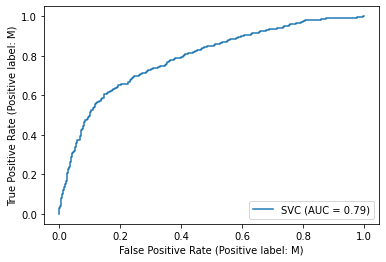

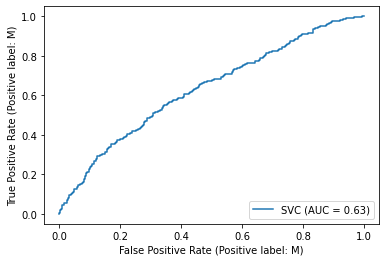

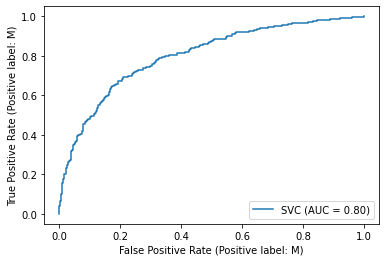

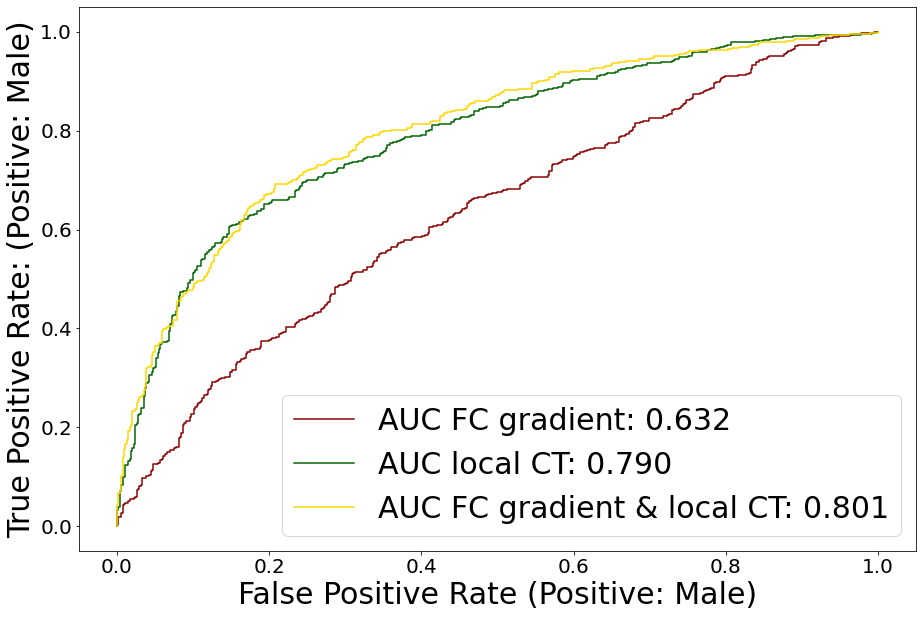

In [6]:
# TRAIN

##### define predictor and target variables

### target: sex
y_GSP = GSP_demographics_cleaned['sex']


### predictor: brain data (400 parcels)
x_GSP_struct = GSP_ct_schaefer400
x_GSP_func = GSP_fc_grad


## confound removal (removing structural and functional data's confounding variables respectively)

# make a preprocessor confound regressor
confound_regressor_struct = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'global_ct']]), X = np.array(x_GSP_struct))
confound_regressor_func = ConfoundRegressor(confound = np.array(GSP_demographics_cleaned[['age', 'icv']]), X = np.array(x_GSP_func))

# fit it to the predictor data
_ = confound_regressor_struct.fit(X = np.array(x_GSP_struct))
_ = confound_regressor_func.fit(X = np.array(x_GSP_func))

# transform the predictor data with confound variables regressed out
x_GSP_struct_unconf = confound_regressor_struct.transform(X = np.array(x_GSP_struct))
x_GSP_func_unconf = confound_regressor_func.transform(X = np.array(x_GSP_func))

# concatenate the two arrays stored in one predictor variable (800 parcels (400 structural, 400 functional)
x_GSP_both_unconf = np.concatenate((x_GSP_struct_unconf, x_GSP_func_unconf), axis = 1)



##### preprocess

scaler_struct = StandardScaler()
_ = scaler_struct.fit(x_GSP_struct_unconf)
x_GSP_struct_unconf_scaled = scaler_struct.transform(x_GSP_struct_unconf)

scaler_func = StandardScaler()
_ = scaler_func.fit(x_GSP_func_unconf)
x_GSP_func_unconf_scaled = scaler_func.transform(x_GSP_func_unconf)


# concatenate the two (preprocessed, i.e., scaled) arrays stored in one predictor variable (800 parcels (400 structural, 400 functional)
x_GSP_both_unconf_scaled = np.concatenate((x_GSP_struct_unconf_scaled, x_GSP_func_unconf_scaled), axis = 1)



##### models

model_struct = SVC(kernel='rbf')
_ = model_struct.fit(x_GSP_struct_unconf_scaled, y_GSP)

model_func = SVC(kernel='rbf')
_ = model_func.fit(x_GSP_func_unconf_scaled, y_GSP)

model_both = SVC(kernel='rbf')
_ = model_both.fit(x_GSP_both_unconf_scaled, y_GSP)





# TEST

##### define predictor and target variables

### target: sex
y_HCP = HCP_demographics_cleaned['sex']


### predictor: brain data (400 parcels)
x_HCP_struct = HCP_ct_schaefer400
x_HCP_func = HCP_fc_grad


## confound removal (removing structural and functional data's confounding variables respectively)

# make a preprocessor confound regressor
confound_regressor_struct = ConfoundRegressor(confound = np.array(HCP_demographics_cleaned[['age', 'global_ct']]), X = np.array(x_HCP_struct))
confound_regressor_func = ConfoundRegressor(confound = np.array(HCP_demographics_cleaned[['age', 'icv']]), X = np.array(x_HCP_func))

# fit it to the predictor data
_ = confound_regressor_struct.fit(X = np.array(x_HCP_struct))
_ = confound_regressor_func.fit(X = np.array(x_HCP_func))

# transform the predictor data with confound variables regressed out
x_HCP_struct_unconf = confound_regressor_struct.transform(X = np.array(x_HCP_struct))
x_HCP_func_unconf = confound_regressor_func.transform(X = np.array(x_HCP_func))



##### preprocess - scale using prefitted scaler on GSP data (correct?) by simply transforming because this is test data 
    # this is what is instructed at https://stackoverflow.com/questions/57775530/why-does-calling-transform-on-test-data-return-an-error-that-the-data-is-not-f?rq=1

x_HCP_struct_unconf_scaled = scaler_struct.transform(x_HCP_struct_unconf)
x_HCP_func_unconf_scaled = scaler_func.transform(x_HCP_func_unconf)

# concatenate the two arrays stored in one predictor variable (800 parcels (400 structural, 400 functional)
x_HCP_both_unconf_scaled = np.concatenate((x_HCP_struct_unconf_scaled, x_HCP_func_unconf_scaled), axis = 1)



##### compute prediction accuracy
score_struct = model_struct.score(x_HCP_struct_unconf_scaled, y_HCP)
score_func = model_func.score(x_HCP_func_unconf_scaled, y_HCP)
score_both = model_both.score(x_HCP_both_unconf_scaled, y_HCP)

print(f"Out-of-sample prediction accuracy for model including only local CT: {score_struct:.3f}")
print(f"Out-of-sample prediction accuracy for model including only functional gradient: {score_func:.3f}")
print(f"Out-of-sample prediction accuracy for model including both local CT and functional gradient: {score_both:.3f}")


##### plot ROC curves

# calculating and plotting ROC for each individually (need to assign value to variable in order to include the .roc_auc value in the graph including 3 models)
ROC_struct = RocCurveDisplay.from_estimator(model_struct, x_HCP_struct_unconf_scaled, y_HCP)
ROC_func = RocCurveDisplay.from_estimator(model_func, x_HCP_func_unconf_scaled, y_HCP)
ROC_both = RocCurveDisplay.from_estimator(model_both, x_HCP_both_unconf_scaled, y_HCP)


# plotting the ROC curves in the same plot
fig, ax = plt.subplots(figsize=(15, 10))

ROC_func = RocCurveDisplay.from_estimator(model_func, x_HCP_func_unconf_scaled, y_HCP, ax = ax, label = "AUC FC gradient: %1.3f" %ROC_func.roc_auc, color='darkred')
ROC_struct = RocCurveDisplay.from_estimator(model_struct, x_HCP_struct_unconf_scaled, y_HCP, ax = ax, label = "AUC local CT: %1.3f" %ROC_struct.roc_auc, color='darkgreen')
ROC_both = RocCurveDisplay.from_estimator(model_both, x_HCP_both_unconf_scaled, y_HCP, ax = ax, label = "AUC FC gradient & local CT: %1.3f" %ROC_both.roc_auc, color='gold')

ax.set_xlabel('False Positive Rate (Positive: Male)', size=30)
ax.set_ylabel('True Positive Rate: (Positive: Male)', size=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
           
plt.legend(prop={'size': 30})

# attempting to obtain features...?

In [52]:
model_both.support_vectors_.shape

(1362, 800)

In [54]:
model_both.support_vectors_.shape

(1362, 800)

In [59]:
model_both.dual_coef_.shape

(1, 1362)

In [174]:
print('b = ', model_both.intercept_)
print('Indices of support vectors = ', model_both.support_)
print('Support vectors = ', model_both.support_vectors_)
print('Number of support vectors for each class = ', model_both.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(model_both.dual_coef_))
print('Number of coefficients of the support vector in the decision function = ', np.abs(model_both.dual_coef_).shape)

b =  [-0.56632919]
Indices of support vectors =  [   1    3    4 ... 1564 1565 1566]
Support vectors =  [[ 0.48598063 -0.66811426 -1.05860876 ... -0.09432214  0.46785621
  -0.46369335]
 [-0.51587322  0.89673548 -0.9293389  ...  0.4616498   0.69256796
   0.85861885]
 [ 0.4917614  -0.0271252  -0.13904656 ... -0.52704208 -0.43234023
  -0.34953452]
 ...
 [ 1.37202703 -0.12785197 -0.2630806  ... -3.0168924   0.7817022
  -0.83393755]
 [ 0.12058705  1.53662009  0.34710144 ...  0.46570485  0.27153755
   0.45476713]
 [ 1.08124197 -0.28026577 -1.13230577 ...  0.2774659   0.03916664
   1.00210895]]
Number of support vectors for each class =  [759 603]
Coefficients of the support vector in the decision function =  [[1.         0.74873736 1.         ... 1.         0.27220179 1.        ]]
Number of coefficients of the support vector in the decision function =  (1, 1362)


In [213]:
model_both.predict_proba(x_HCP_both_unconf_scaled).shape

(1014, 2)

In [214]:
model_both.predict_proba(x_HCP_both_unconf_scaled)

array([[1.55188022e-05, 9.99984481e-01],
       [4.07417862e-01, 5.92582138e-01],
       [7.21590618e-01, 2.78409382e-01],
       ...,
       [7.55565609e-01, 2.44434391e-01],
       [4.31699244e-02, 9.56830076e-01],
       [6.68457123e-01, 3.31542877e-01]])

In [41]:
# sequential feautre selection

sfs = SFS(model_both, n_features_to_select='warn', tol=None, direction='forward', scoring=None, cv=None, n_jobs=None)

In [42]:
sfs

SequentialFeatureSelector(cv=None, estimator=SVC())

In [ ]:
sfs = SFS(lr, k_features=7, forward=True, floating=False, n_jobs=-1,
              scoring='neg_mean_absolute_error', cv=False)

### TRYING TO INCLUDE CATEGORICAL CONFOUND REGRESSION BELOW: ERROR
### TROUBLESHOOT https://techoverflow.net/2019/05/22/how-to-fix-numpy-typeerror-cannot-cast-ufunc-subtract-output-from-dtypefloat64-to-dtypeint64-with-casting-rule-same_kind/

#
#
#
#
# for some reason I get better results when fitting the ROC curve...
example -> need to decide after what code I want to run this (see X and y variables)

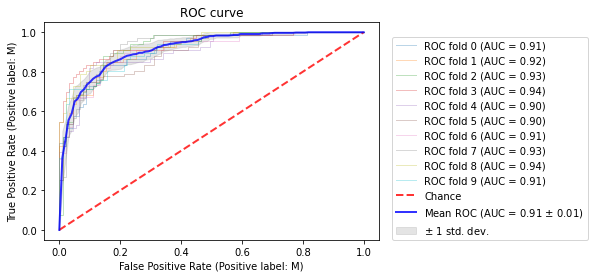

In [27]:
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
###cv = cross_validate(cv = 10)
#classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

X = x_GSP_unconf
y = y_GSP

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC curve",
)
ax.legend(loc=(1.04, 0))
plt.show()

#
#
#
#
# Sofie's script

In [ ]:
'''
This is a python script for running supervised machine learning to predict compassion score

data input : foldname

data output $np.save..... 
'''

import numpy as np
import pandas as pd
import scipy.stats as ss
import sklearn.linear_model as slm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
warnings.filterwarnings("ignore")

df_data = pd.read_csv ('../data/attention_data.csv')
sex_code = df_data['sex1'].unique()
if type(sex_code[0]) == str:
    sex_dict = {k: idx for idx, k in enumerate(sex_code)}
    df_data['sex1'] = df_data['sex1'].replace(sex_dict)  


def model_elasticnet(m): # l1_ratio
  print('m', str(m))

  dic = {}
  for i in range(sample): 
    lr = slm.ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], l1_ratio=m, cv=5)
    sfs = SFS(lr, k_features=7, forward=True, floating=False, n_jobs=-1,
              scoring='neg_mean_absolute_error', cv=False)
    model = sfs.fit(x_correct[i], y_train[i])
    x_1 = model.transform(x_correct[i])
    x_2 = model.transform(x_test_corr[i])
    model2 = lr.fit(x_1, y_train[i])
    y_pred = lr.predict(x_2)
    corr = ss.pearsonr(y_pred, y_test[i])
    a = model.get_metric_dict()[7]
    a['importance'] = model.estimator.coef_
    a['intercept'] = model.estimator.intercept_
    a['alpha_best'] = model.estimator.alpha_
    a['predict_test_r_p'] = np.array(corr)
    a['mean_lr_mse']  = model2.mse_path_.mean()
    dic['train_test_'+str(i+1)] = a
    print('finish model......', str(i+1))
    print(a)
  np.save('../results/'+foldname+'feature_20_l1ratio_' + str(m)+ 'zscore.npy', dic)
  return print('feature_' + str(20) + '_l1ratio_' + str(m)+'   finished')

foldname=['attention']
for foldname in foldname:

  # IMPORT sample train_test iterations
  sample = 100

  x_train = [None] * sample
  y_train = [None] * sample
  x_test = [None] * sample
  y_test = [None] * sample
  x_correct = [None]  * sample
  x_test_corr = [None] * sample
  for i in range(sample):
    Y_col = 'val1'
    X_cols = df_data.loc[:, df_data.columns != Y_col].columns

    x_train[i], x_test[i], y_train[i], y_test[i] = train_test_split(        
          df_data[X_cols], df_data.iloc[:, 1], test_size=0.3, random_state=i)
	
    x_conf = x_train[i].iloc[:,[2,3]]
    y_conf = x_train[i].iloc[:,4:39]
    x, y   = np.array(x_conf), np.array(y_conf)
    model_conf = LinearRegression().fit(x, y)
    y_pred = model_conf.predict(x)
    x_correct[i] = y  - y_pred
    x_conf = x_test[i].iloc[:,[2,3]]
    y_conf = x_test[i].iloc[:,4:39]
    x, y   = np.array(x_conf), np.array(y_conf)
    model_conf = LinearRegression().fit(x, y)
    y_pred = model_conf.predict(x)
    x_test_corr[i] = y  - y_pred


  regulation = [1.0]

  for j in regulation:
    model_elasticnet(m=j)